# Projeto de NLP: Análise de Sentimento em Manchetes de Notícias: Insights de Investimento para Ações da Facebook (FB) e Tesla (TSLA)

 🎯 **Objetivo:** Utilizar **análise de sentimento** nas **manchetes de notícias** financeiras do FINVIZ.com para identificar tendências do mercado e analisar o desempenho das ações, permitindo decisões de investimento mais informadas e potencialmente lucrativas.

🔗**Fonte:** Esse projeto foi proposto pela trilha de aprendizados do DataCamp para testar e treinar **conceitos de NLP** (natural language processing ou  processamento de linguagem natural).

📰  **Dados:** [FINVIZ](https://finviz.com/) tem uma lista de sites confiáveis, e as manchetes desses sites tendem a ser mais consistentes em seu jargão do que as de blogueiros independentes. Padrões textuais consistentes melhorarão a análise de sentimento.

🔢 **Passos:**

1. Lendo os arquivos HTML
2. Entendendo os arquivos HTML
3. Extraindo as manchetes
4. Analisando sentimentos.
5. Prevendo os sentmentos.
6. Analisando os sentimentos ao longo do tempo
7. Fazendo alguns ajustes
8. Sentimento em um único dia de negociação e ações
9. Visualizando


## 1. Lendo os arquivos HTML

Vamos começar lendo e processando as manchetes oriundas de um **webscraping de 5 momentos diferentes do site da FINVI**Z, os arquivos estão em  HTML localizados em uma pasta chamada datasets.

Utilizando a biblioteca BeautifulSoup para análise de HTML, o código itera sobre cada arquivo na pasta, abre o arquivo em modo de leitura e parseia seu conteúdo. A partir desse conteúdo, ele busca por uma tabela específica identificada pelo id `news-table`.

Cada tabela encontrada é então armazenada em um dicionário, onde a chave é o nome do arquivo e o valor é o objeto da tabela. Isso permite uma organização eficiente e acesso rápido às tabelas extraídas para análises ou manipulações subsequentes.



In [ ]:
# Importando bibliotecas
from bs4 import BeautifulSoup
import os

#Criando um dicionário vazio para preencher com as informações
html_tables = {}

# Para cada tabela na pasta datasets...
for table_name in os.listdir('datasets'):
    # Este é o caminho para o arquivo. Provavelmente deve ser alterado
    table_path = f'/content/datasets/{table_name}'
    # Abrindo como um arquivo Python em modo somente leitura
    table_file = open(table_path, 'r')
    # Lendo o conteúdo do arquivo para 'html'
    html = BeautifulSoup(table_file)
    # Encontrando 'news-table' no BeautifulSoup e carregar em 'html_table'
    html_table = html.find(id='news-table')
    # Adicionando a tabela ao nosso dicionário
    html_tables[table_name] = html_table


## 2. Entendendo os arquivos HTML


Pegamos a tabela que contém os títulos do arquivo HTML de cada ação, mas antes de começarmos a analisar essas tabelas ainda mais, precisamos entender como os dados dessa tabela estão estruturados.

In [ ]:
# Lendos um dos dias de manchetes
tsla = html_tables['tsla_22sep.html']
# Obtenhendo todas as linhas da tabela <tr> no arquivo e armazenando em 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# Para cada linha...
for i, table_row in enumerate(tsla_tr):
    # Lendo o texto do elemento 'a' e armazenando em 'link_text'
    link_text = table_row.a.get_text()
    # Lendo o texto do elemento <td> e armazenando em 'data_text'
    data_text = table_row.td.get_text()
    # Imprimindo a contagem
    print(f'Número do arquivo {i+1}:')
    # Imprimindo o conteúdo de 'link_text' e 'data_text'
    print(link_text)
    print(data_text)
    # Encerraremos o loop depois de quatro linhas para evitar sobrecarregar o notebook, (nem mexe nisso aqui hihi)
    if i == 3:
        break


Número do arquivo 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
Número do arquivo 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
Número do arquivo 3:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
Número do arquivo 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3. Extraindo as manchetes

Como vimos acima, os dados interessantes dentro de cada linha da tabela (`<tr>`) estão no texto dentro das tags `<td>` e `<a>`. Vamos agora analisar os dados de todas as tabelas e estruturar os dados.

In [ ]:
# Armazenando as notícias analisadas em uma lista
parsed_news = []
# Iterando pelas notícias
for file_name, news_table in html_tables.items():
    # Iterando por todas as tags <tr> em 'news_table'
    for x in news_table.findAll('tr'):
        # Lendo o texto da tag <tr> e armazene em 'text'
        text = x.get_text()
        # Dividindo o texto da tag <td> em uma lista
        date_scrape = x.td.text.split()
        # Separando a data e a hora das manchetes de forma adequada
        # Se o comprimento de 'date_scrape' for 1, carregue 'time' com o único elemento
        # Caso contrário, carregue 'date' com o primeiro elemento e 'time' com o segundo
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extraindo o ticker do nome do arquivo, obtendo a string até o primeiro '_'
        ticker = file_name.split("_")[0]
        # Adicionando ticker, data, hora e manchete como uma lista à lista 'parsed_news'
        parsed_news.append([ticker, date, time, x.a.text])


In [ ]:
parsed_news[5]

['fb', 'Jan-04-19', '02:46PM', 'Facebook to Prioritize Video in 2019']

## 4. Analisando sentimentos.

Com uma base estruturada podemos partir para a analise de sentimentos das manchetes. **A análise de sentimento é altamente dependente do contexto.** Por exemplo, a frase "Isso é tão viciante!" geralmente tem uma conotação positiva se estamos falando de um videogame que você está jogando com amigos, mas pode ter uma conotação negativa quando nos referimos a opioides.

É importante considerar que selecionamos as manchetes para tentar capturar o sentimento dos jornalistas financeiros, que, assim como outros profissionais, possuem uma linguagem específica. Agora, vamos ajustar o NLTK para refletir a perspectiva de um jornalista financeiro, adicionando novas palavras e valores de sentimento ao nosso léxico.


**Detalhamento do ajuste léxico:**
* **'crushes'**: 10: A palavra "crushes" (como em "domina" ou "arrasou") é atribuída um valor positivo alto (+10), indicando um sentimento muito positivo.
* **'beats'**: 5: A palavra "beats" (como em "vence" ou "supera") tem um valor positivo moderado (+5), sugerindo um sentimento positivo.
* **'misses'**: -5: A palavra "misses" (como em "perdeu" ou "sentiu falta") recebe um valor negativo leve (-5), indicando um sentimento levemente negativo.
* **'trouble'**: -10: A palavra "trouble" (como em "problema" ou "dificuldade") tem um valor negativo moderado (-10), sugerindo um sentimento mais negativo.
* **'falls'**: -100: A palavra "falls" (como em "desmorona" ou "cai") é atribuída um valor negativo muito alto (-100), refletindo um sentimento extremamente negativo.

In [ ]:
!pip install NLTK

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Importando NLTK VADER para análise de sentimento
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Definindo novo léxico (novas palavras e valores)
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

# Instanciando o analisador de intensidade de sentimento com o léxico existente
vader = SentimentIntensityAnalyzer()

# Atualizando o léxico
vader.lexicon.update(new_words)


## 5. Prevendo os sentmentos.


Agora que temos os dados e o algoritmo carregados, chegaremos ao cerne da questão: prever o sentimento das manchetes! Felizmente para nós, o VADER é de nível muito alto, então, neste caso, não ajustaremos o modelo além das adições de léxico anteriores.
VADER “pronto para uso” com algum léxico extra provavelmente se traduziria em pesadas perdas com dinheiro real. Uma verdadeira ferramenta de análise de sentimento com chances de ser lucrativa exigirá um léxico de notícias muito extenso e dedicado ao financiamento. Além disso, também pode não ser suficiente usar um modelo pré-treinado como o VADER.

In [ ]:
import pandas as pd
# Definindo os nomes da coluna
columns = ['ticker', 'date', 'time', 'headline']
# Convertendo a lista de manchetes em um DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterando pelas manchetes e obtenha os escores de polaridade
scores = [vader.polarity_scores(headline) for headline in scored_news.headline]
# Convertendo a lista de dicionários em um DataFrame
scores_df = pd.DataFrame(scores)
scored_news.columns = columns
# Juntando os DataFrames
scored_news = scored_news.join(scores_df)
# Convertendo a coluna de data de string para data
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date


<ipython-input-25-7ee2c8948c14>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  scored_news['date'] = pd.to_datetime(scored_news.date).dt.date


In [ ]:
scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,fb,2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.0,0.631,0.369,0.4767
1,fb,2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.0,1.000,0.000,0.0000
2,fb,2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.0,1.000,0.000,0.0000
3,fb,2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.0,1.000,0.000,0.0000
4,fb,2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.0,0.698,0.302,0.3818


## 6. Analisando os sentimentos ao longo do tempo

Agora que temos as pontuações, vamos começar a traçar os resultados. Começaremos traçando a série temporal das ações que temos (fb, tsla).

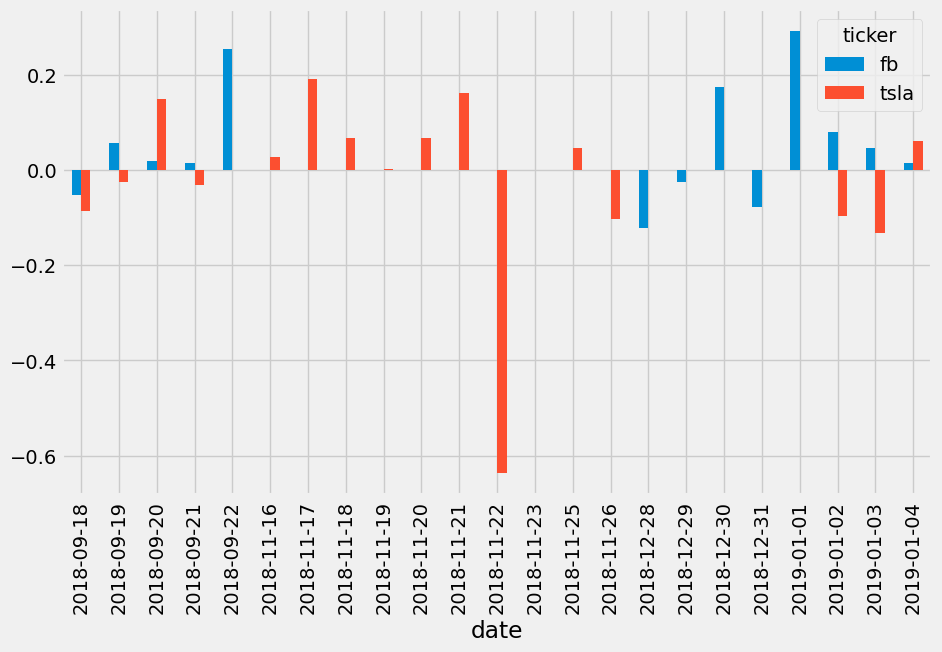

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# Agrupando por data e ticker nas colunas do scored_news e calcule a média (deu um problema no tipo, tivemos que filtrar)
mean_c = scored_news.groupby(['date', 'ticker'])[scored_news.select_dtypes(include='number').columns].mean()
# Desempilhando a coluna ticker
mean_c = mean_c.unstack('ticker')
# Obtendo a seção transversal de 'compound' no eixo das colunas
mean_c = mean_c.xs("compound", axis="columns")
# Plote um gráfico de barras com pandas
mean_c.plot.bar(figsize = (10, 6));


## 7. Fazendo alguns ajustes

O que aconteceu com Tesla em 22 de novembro? Como temos as manchetes em nosso DataFrame, uma rápida olhada revela que há alguns problemas naquele dia específico:

Existem apenas 5 manchetes para aquele dia.
Duas manchetes são literalmente iguais a outra, mas de outro meio de comunicação.
Vamos limpar um pouco o conjunto de dados, mas não muito! Embora algumas manchetes sejam a mesma notícia de fontes diferentes, o fato de serem escritas de forma diferente pode fornecer perspectivas diferentes sobre a mesma história. Além disso, quando uma notícia é mais importante, ela tende a receber mais manchetes de diversas fontes. O que queremos eliminar são as manchetes copiadas literalmente, já que muito provavelmente vêm do mesmo jornalista e estão apenas sendo "encaminhadas", por assim dizer.

In [ ]:
# Contando o número de manchetes em 'scored_news' (armazenado como um inteiro)
num_news_before = scored_news.headline.count()
# Removendo duplicatas com base em 'ticker' e 'headline'
scored_news_clean = scored_news.drop_duplicates(subset=['headline', 'ticker'])
# Contando o número de manchetes após remover duplicatas (armazenado como um inteiro)
num_news_after = scored_news_clean.headline.count()
# Imprimindo os números antes e depois para ter uma ideia de como fizemos
f"Antes tínhamos {num_news_before} manchetes, agora temos {num_news_after}"


'Antes tínhamos 500 manchetes, agora temos 476'

## 8. Sentimento em um único dia de negociação e ações
Apenas para entender as possibilidades desse conjunto de dados e ter uma ideia melhor dos dados, vamos nos concentrar em um dia de negociação e em uma única ação. Faremos um gráfico informativo onde veremos o menor grão possível: título e subpartituras.

In [ ]:
# Defina o índice como 'ticker' e 'date'
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Obtenha a seção transversal da linha 'fb'
single_day = single_day.xs('fb')

# Converta o índice de data para datetime
single_day.index = pd.to_datetime(single_day.index)

# Selecione o dia 3 de janeiro de 2019
single_day = single_day.loc['2019-01-03']
# Converta a string de data e hora para apenas o horário
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# Defina o índice como 'time' e ordene por ele
single_day = single_day.set_index('time')
# Ordene
single_day = single_day.sort_index()


<ipython-input-38-c07d0060b895>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  single_day['time'] = pd.to_datetime(single_day['time']).dt.time


In [ ]:
single_day.head()


,headline,neg,neu,pos,compound
time,,,,,
06:00:00,Why Internet Censorship Doesnt Work and Never ...,0.000,1.000,0.000,0.0000
08:04:00,"3 Big Stock Charts for Thursday: Medtronic, Fa...",0.000,1.000,0.000,0.0000
09:07:00,"The Zacks Analyst Blog Highlights: Facebook, W...",0.000,0.846,0.154,0.2500
09:12:00,Why The FAANGs Are Crucial To A 2019 Market Rally,0.000,1.000,0.000,0.0000
09:34:00,Apple warning stoking fears of slowdown in Chi...,0.426,0.574,0.000,-0.6369


## 9 Visualizando
Faremos um gráfico para visualizar as pontuações positivas, negativas e neutras para um único dia de negociação e uma única ação.

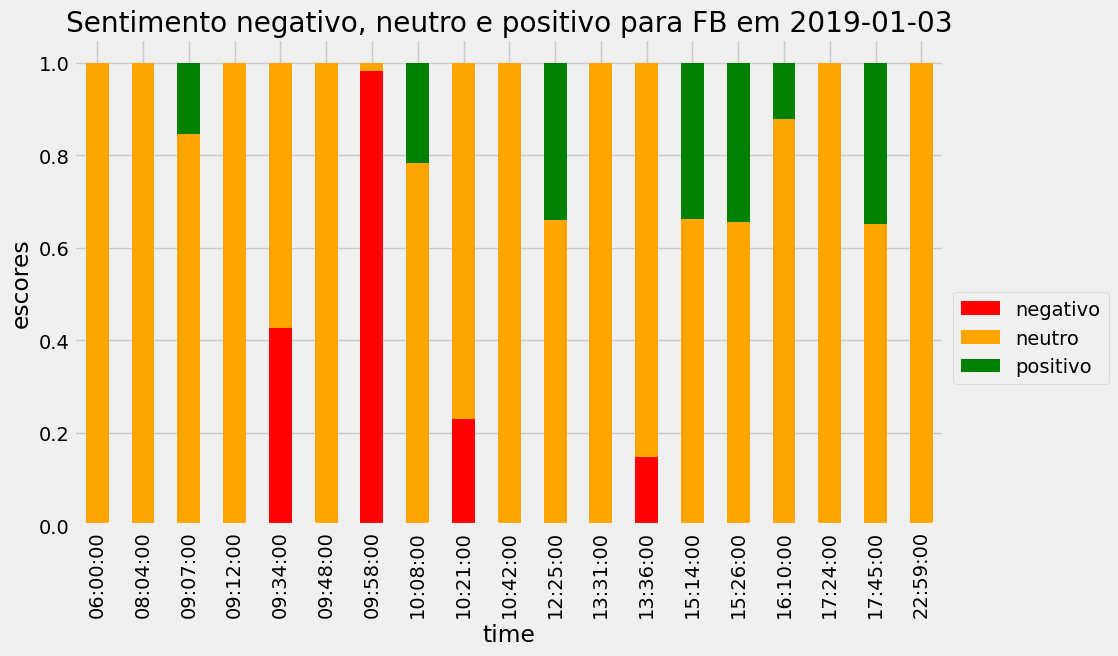

In [ ]:
# Título e cores para o gráfico
TITLE = "Sentimento negativo, neutro e positivo para FB em 2019-01-03"
COLORS = ["red","orange", "green"]

# Remova as colunas que não são úteis para o gráfico
plot_day = single_day.drop(['compound', 'headline'], axis=1)

# Altere os nomes das colunas para 'negativo', 'neutro' e 'positivo'
plot_day.columns = ['negativo', 'neutro', 'positivo']

# Plote um gráfico de barras empilhadas
plot_day.plot.bar(stacked=True, figsize=(10, 6), title=TITLE, color=COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("escores")
plt.show()

O impacto das notícias sobre uma ação, como o Facebook, esse gráfico pode mostrar como o sentimento das notícias mudou ao longo do dia e ajudar a correlacionar esses sentimentos com eventos específicos ou mudanças no mercado, mostrando como esses sentimentos variam ao longo do dia, ajudando a identificar padrões e possíveis influências das notícias no sentimento geral.

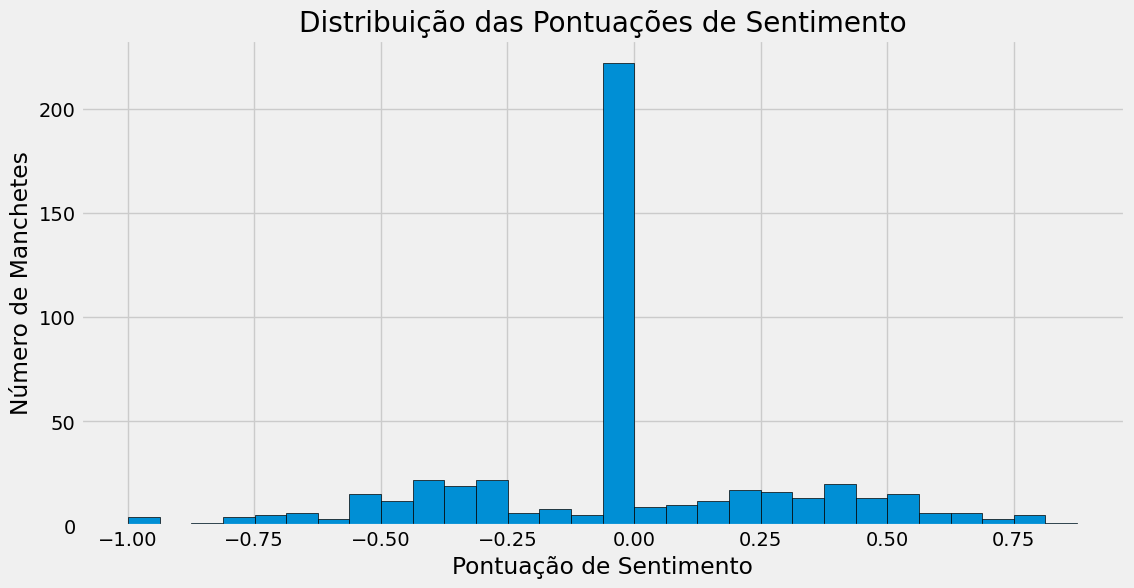

In [ ]:
# Verificando a distribuição das pontuações de sentimento para todas as notícias.
plt.figure(figsize=(12, 6))
plt.hist(scored_news['compound'], bins=30, edgecolor='black')
plt.xlabel('Pontuação de Sentimento')
plt.ylabel('Número de Manchetes')
plt.title('Distribuição das Pontuações de Sentimento')
plt.show()


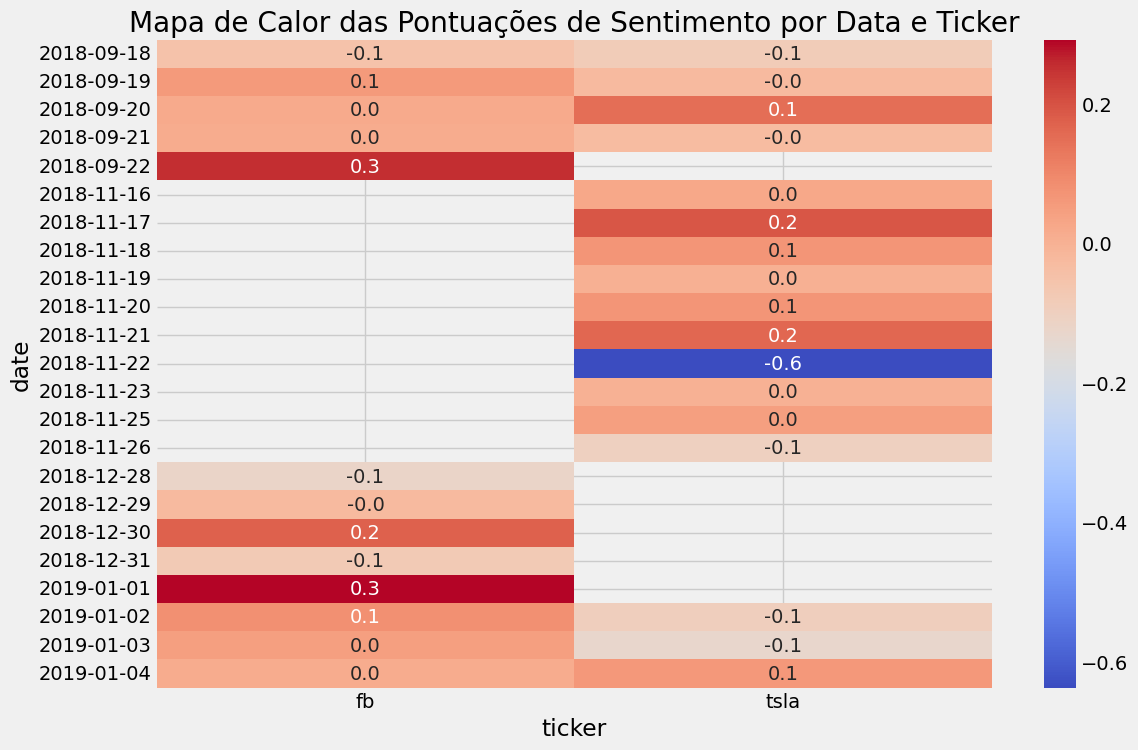

In [ ]:
import seaborn as sns
#Visualize a intensidade média dos sentimentos por dia e por ticker.
# Criar uma tabela de contingência para o mapa de calor
heatmap_data = scored_news.pivot_table(index='date', columns='ticker', values='compound', aggfunc='mean')

# Plotar o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.1f')
plt.title('Mapa de Calor das Pontuações de Sentimento por Data e Ticker')
plt.show()


In [ ]:
single_day.head()

,headline,neg,neu,pos,compound
time,,,,,
06:00:00,Why Internet Censorship Doesnt Work and Never ...,0.000,1.000,0.000,0.0000
08:04:00,"3 Big Stock Charts for Thursday: Medtronic, Fa...",0.000,1.000,0.000,0.0000
09:07:00,"The Zacks Analyst Blog Highlights: Facebook, W...",0.000,0.846,0.154,0.2500
09:12:00,Why The FAANGs Are Crucial To A 2019 Market Rally,0.000,1.000,0.000,0.0000
09:34:00,Apple warning stoking fears of slowdown in Chi...,0.426,0.574,0.000,-0.6369


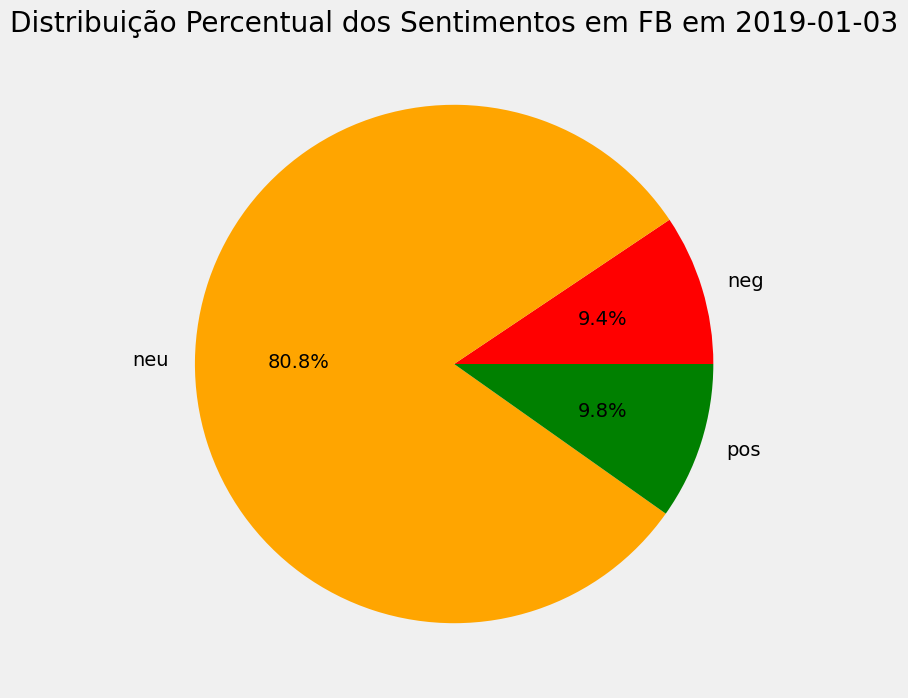

In [ ]:
# Calcular a soma dos sentimentos para o dia selecionado
sentiment_counts = single_day[['neg', 'neu', 'pos']].sum()

# Plotar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'orange', 'green'])
plt.title('Distribuição Percentual dos Sentimentos em FB em 2019-01-03')
plt.show()

